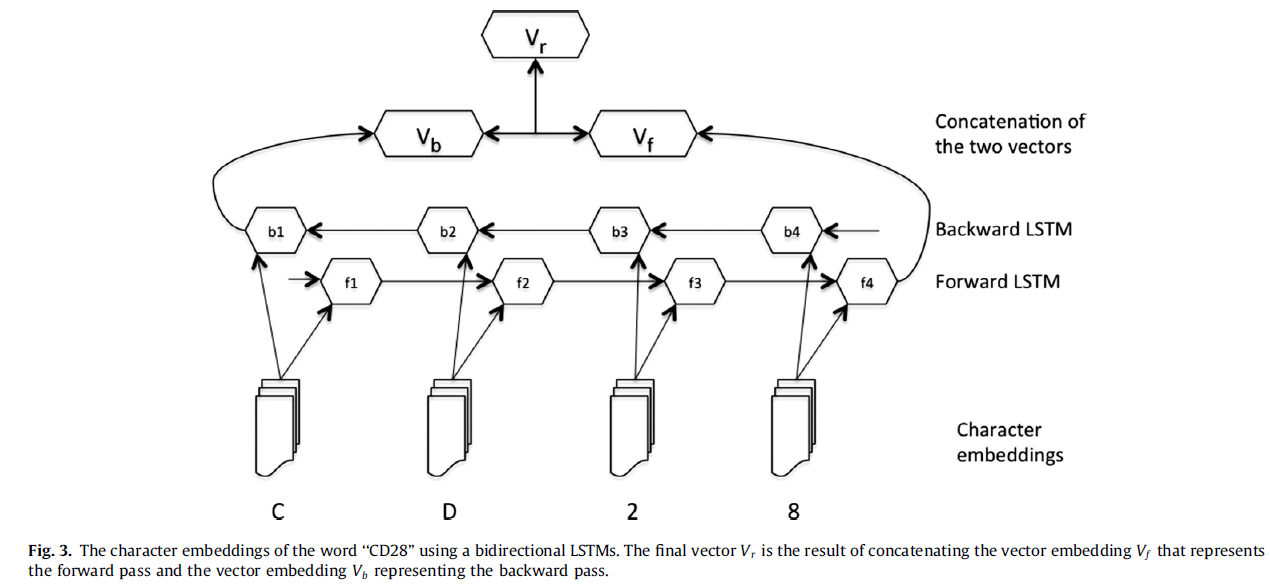

**Article title: Character-level neural network for biomedical named entity recognition**

**Article author: Mourad Gridacht**

**Student: Ivana Nastasic (student number: 1852026)**

Goal of this project is to implement in Python programming language some of the experiments presented in the article.

Article is treating a problem of Biomedical named entity recognition (BNER), as a specific natural language processing problem of automated extracting of important named entities such as genes and proteins from biomedical texts. 
In the past there were three common approaches in solving these type of problems, rule-based, dictionary-based and machine learning approaches (treating it as sequence labeling problem). Author explored use of DNN for resolving this challenge.

Important part of the work are word embeddings, where author implemented character-based word embeddings together with pretrained word embeddings. Biomedical texts contain more complex words (e.g. hyperbilirubinemia and oligonucleotide) than an ordinary text and in general have relatively high out-of-vocabulary (OOV) rates. It has been shown that word-level embeddings suffer from the out-of-vocabulary (OOV) problem, which makes the system unable to generalize on rare and unseen words. Adding character-level embeddings allow
system to learn interesting morphological and orthographic features without engineering them by hand. Bidirectional LSTMs are used to compute character-based vector embeddings of words as it is shown in Figure 3. 

For word embeddings author tried different pretrained word embeddings implementations, and the most significant result is obtained using word2vec embeddings developed in the context of biomedical natural language processing induced from PubMed and PMC texts.

In total five different DNN architectures were used in experiments: 
1. LSTM with pretrained word embeddings (LSTM + WE)
2. Bidirectional LSTM with pretrained word embeddings (BLSTM +WE)
3. The combination of BILSTM, pretrained word embeddings and character-level embeddings (BLSTM +WE + char)
4. Bidirectional LSTM, character-level embeddings, pretrained word embeddings and dropout (BLSTM +WE + char + dropout)
5. Bidirectional LSTM, character-level embeddings, pretrained word embeddings and dropout(BLSTM + WE + char + dropout + CRF)

Architecture of the final model 5 which acheived best results is presented in the Figure 4.

Stochastic Gradient Descent (SGD) is used to train models.
Learning rate was fixed to 0.01. DNN networks were trained using the backpropagation through time algorithm to update model parameters. Gradient
clipping of 5.0 was used in order to reduce the exploding gradient problem.

All the experiments are conducted on two datasets, JNLPBA and BioCreAtIvE II GM.

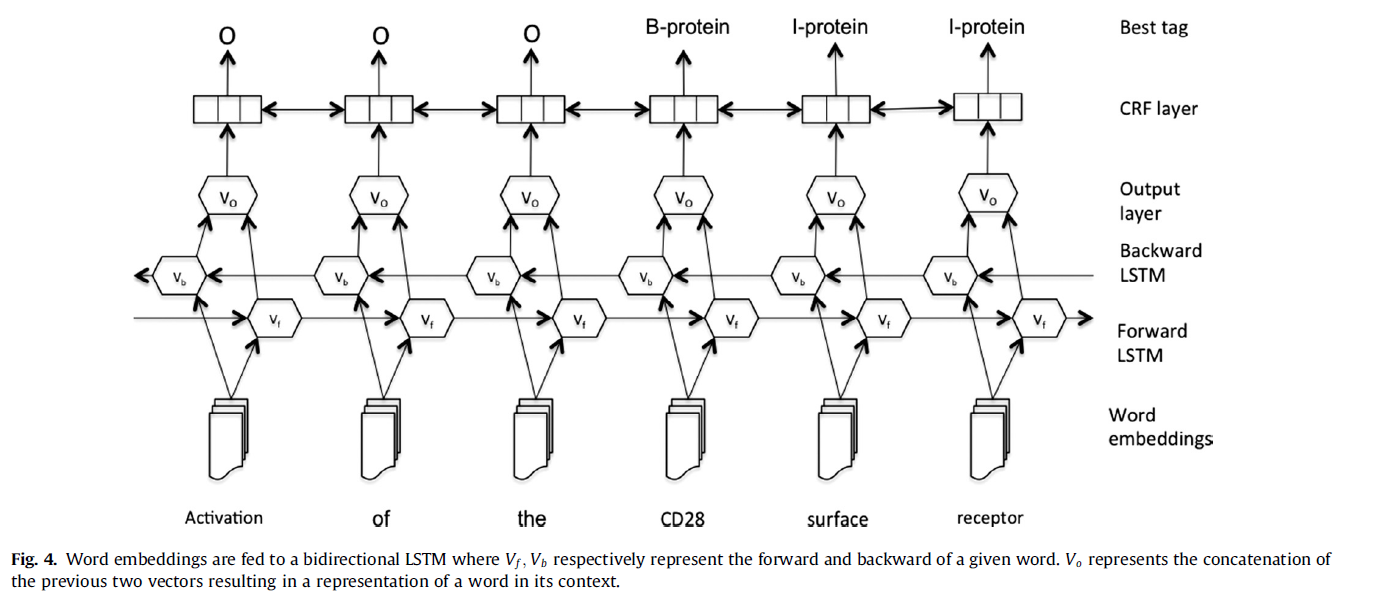

In my work, I recreted experiments 3-5 (BLSTM +WE + char, BLSTM +WE + char + dropout and BLSTM +WE + char + dropout + CRF) on the dataset JNLPBA downloaded from the GENIA website.

http://www.geniaproject.org/shared-tasks/bionlp-jnlpba-shared-task-2004

In [ ]:
# Installing libraries
!pip install tensorflow-gpu==2.3.1
!pip install sklearn_crfsuite==0.3.6
!pip install tf2crf==0.1.24

     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 747kB 8.1MB/s 


In [ ]:
# Importing libraries
import string
import pickle
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from keras.callbacks import Callback
import os
from tqdm import tqdm
from tensorflow.keras import models
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tf2crf import CRF
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


********************************************************************************
Code from outside sources
********************************************************************************

In [ ]:
class F1Metrics(Callback):
    '''
    Class that compute the F1 score and works as Callback for Keras which enables calculation of F1 score after each epoch.
    
    Code with small modifications is taken from the article "How to compute f1 score for named-entity recognition in Keras", published on Towards Data Science
    https://towardsdatascience.com/how-to-compute-f1-score-for-named-entity-recognition-in-keras-6f28b31dccca

    '''
    def __init__(self, id2label, pad_value=0, validation_data=None):
        '''
        Class initialization
        Args:
            id2label (dict): id to label mapping (e.g. {1: 'B-LOC', 2: 'I-LOC'})
            pad_value (int): padding value
            validation data: part of the dataset used for validation
        '''
        super(F1Metrics, self).__init__()
        self.id2label = id2label
        self.labels = [label for label in id2label.values() if label not in ['o', '<oov>']] #removing padding
        self.pad_value = pad_value
        self.validation_data = validation_data
        self.is_fit = validation_data is None

    def find_pad_index(self, array):
        '''
        Find index from where padding started.
        Args:
            array (list): padded list
        Returns:
            idx: padding index
        Examples:
             >>> array = [1, 2, 0]
             >>> self.find_pad_index(array)
             2
        '''
        try:
            return list(array).index(self.pad_value)
        except ValueError:
            return len(array)

    def get_length(self, y):
        '''
        Get true (without padding) length of each padded list y.
        Args:
            y (list): list of padded lists
        Returns:
            lens: list of true lengths of each list within y
        Examples:
            >>> y = [[1, 0, 0], [1, 1, 0], [1, 1, 1]]
            >>> self.get_length(y)
            [1, 2, 3]
        '''
        lens = []
        for row in y:
            lens.append(row[row != 0].shape[0])

        return lens

    def convert_idx_to_name(self, y, lens):
        '''
        Convert label index to its' name.
        Args:
            y (list): list of label index lists
            lens (list): true length of each list within y
        Returns:
            y: label name list
        Examples:
            >>> # assumes that id2label = {1: 'B-LOC', 2: 'I-LOC'}
            >>> y = [[1, 0, 0], [1, 2, 0], [1, 1, 1]]
            >>> lens = [1, 2, 3]
            >>> self.convert_idx_to_name(y, lens)
            [['B-LOC'], ['B-LOC', 'I-LOC'], ['B-LOC', 'B-LOC', 'B-LOC']]
        '''
        y = [[self.id2label[idx] for idx in row[:l]]
             for row, l in zip(y, lens)]
        return y

    def predict(self, X, y):
        '''
        Predict sequence of labels.
        Args:
            X (list): input dataset
            y (list): true label indexes
        Returns:
            y_true: true sequences of label names
            y_pred: predicted sequences of label names
        '''

        y_pred = self.model.predict_on_batch(X)

        lens = self.get_length(y)

        y_true = self.convert_idx_to_name(y, lens)
        y_pred = self.convert_idx_to_name(y_pred, lens)

        return y_true, y_pred

    def score(self, y_true, y_pred):
        ''' 
        Calculate F1 score.
        Args:
            y_true (list): true sequences of labels
            y_pred (list): predicted sequences of labels
        Returns:
            score: F1 score
        '''
        score = flat_f1_score(y_true, y_pred, average='weighted', labels=self.labels, zero_division=0)
        print(' - f1: {:04.5f}'.format(score * 100))

        report = flat_classification_report(y_pred=y_pred, y_true=y_true, zero_division=0)
        print(report)
        return score

    def on_epoch_end(self, epoch, logs={}):
      '''
      Evaluates results after each epoch
      '''
      # Called in case that validation data generator is not provided
      if self.is_fit:
        self.on_epoch_end_fit(epoch, logs)

        # Called in case that validation data generator is provided    
      else:
        self.on_epoch_end_fit_generator(epoch, logs)

    def on_epoch_end_fit(self, epoch, logs={}):
      '''
      Evaluates results after each epoch on whole validation dataset
      Returns: F1 score and saves value into epoch log
      '''
      X = self.validation_data[0]
      y = self.validation_data[1]
      y_true, y_pred = self.predict(X, y)
      score = self.score(y_true, y_pred)
      logs['f1'] = score

    def on_epoch_end_fit_generator(self, epoch, logs={}):
      '''
      Evaluates results after each epoch using predictions on batches of validation dataset
      Returns: F1 score and saves value into epoch log
      '''
      y_true = []
      y_pred = []
      for X, y in self.validation_data:
        y_true_batch, y_pred_batch = self.predict(X, y)
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)
      score = self.score(y_true, y_pred)
      logs['f1'] = score

In [ ]:
def pad_to_dense(M):
    '''
        Appends the minimal required amount of zeroes at the end of each list in M, in a way that all lists become of the same length.
        Code is taken from Stackoverflow post: https://stackoverflow.com/questions/37676539/numpy-padding-matrix-of-different-row-size
         Args:
          M (list): list of lists of different length
         Returns: padded list (each list has the same lenght)
    '''
    maxlen = max(len(r) for r in M)
    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
      Z[enu, :len(row)] += row
    return Z

In [ ]:
class Score():

  '''
  Class which computes the F1 Score on model predictions.
  '''

  def __init__(self,y_true,y_pred,id2label,pad_value):
    '''
    Class initialization.
    Args:
        y_true: true labels
        y_pred: predicted labels
        id2label (dict): id to label mapping (e.g. {1: 'B-LOC', 2: 'I-LOC'})
        pad_value (int): padding value
    '''
    self.y_true = y_true
    self.y_pred = y_pred
    self.id2label = id2label
    self.labels = [label for label in id2label.values() if label not in ['o', '<oov>']]
    self.pad_value = pad_value

  def find_pad_index(self,array):
        '''
        Find index from where padding started.
        Args:
            y (list): padded list
        Returns:
            idx: padding index
        Examples:
             >>> array = [1, 2, 0]
             >>> self.find_pad_index(array)
             2
        '''
        try:
            return list(array).index(self.pad_value)
        except ValueError:
            return len(array)

  def get_length(self,y):
          '''
          Get true (without padding) length of each padded list y.
          Args:
              y (list): padded list
          Returns:
              lens: true length of y
          Examples:
              >>> y = [[1, 0, 0], [1, 1, 0], [1, 1, 1]]
              >>> self.get_length(y)
              [1, 2, 3]
          '''
          lens = [self.find_pad_index(row) for row in y]

          return lens

  def convert_idx_to_name(self, y, lens):
        '''
        Convert label index to its' name.
        Args:
            y (list): label index list
            lens (list): true length of y
        Returns:
            y: label name list
        Examples:
            >>> # assumes that id2label = {1: 'B-LOC', 2: 'I-LOC'}
            >>> y = [[1, 0, 0], [1, 2, 0], [1, 1, 1]]
            >>> lens = [1, 2, 3]
            >>> self.convert_idx_to_name(y, lens)
            [['B-LOC'], ['B-LOC', 'I-LOC'], ['B-LOC', 'B-LOC', 'B-LOC']]
        '''
        y = [[self.id2label[idx] for idx in row[:l]]
             for row, l in zip(y, lens)]
        return y
        
        
  def score(self):
    '''
    Calculate F1 score and print classification report.
    '''
    lens = self.get_length(self.y_true)
    y_true_idx = self.convert_idx_to_name(y=self.y_true, lens=lens)
    y_pred_idx = self.convert_idx_to_name(y=self.y_pred, lens=lens)

    score = flat_f1_score(y_true=y_true_idx, y_pred=y_pred_idx, average='weighted', labels=self.labels, zero_division=0)
    #print(' - f1: {:04.5f}'.format(score * 100))
    report = flat_classification_report(y_pred=y_pred_idx, y_true=y_true_idx, zero_division=0)
    print(report)
    return score


********************************************************************************
Utility functions
********************************************************************************

In [ ]:
def getCharVocab():
    """
    Maps all characters (lowercase ascii characters, digits and punctuation) to numbers and vice versa
    Return: Two dictionaries: {key = word, value = assigned_num} {key = assigned_num, value = word}
    """
    chars = list(string.ascii_lowercase+string.digits+string.punctuation)
    char2num = {'<PAD>': 0, '<OOV>': 1}
    num2char = {0: '<PAD>', 1: '<OOV>'}
    for i in range(len(chars)):
        char2num[chars[i]] = 2 + i
        num2char[2 + i] = chars[i]
    return num2char, char2num

In [ ]:
def getDataset():
    """
    Reads saved cleaned datasets
    Return: texts, labels, max length of the words in the texts
    """
    
    dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/pickle_files/train/"
    

    # Read
    with open(dir+"texts.pkl", "rb") as f:
        texts = pickle.load(f)
    with open(dir+"labels.pkl", "rb") as f:
        labels = pickle.load(f)
    with open(dir+"max_len_word.pkl", "rb") as f:
        max_len_word = pickle.load(f)
    return texts, labels, max_len_word

In [ ]:
def getMappings():
    """
    Reads saved mappings
    Return: List of dictionaries: {key:assigned num, value = label}, {value = label, key:assigned num}, {key:assigned num, value = word}, {value = word, key:assigned num}
    """
    dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/pickle_files/train/"

    with open("number2tag.pkl", "rb") as f:
        num2tag = pickle.load(f)
    with open(dir+"tag2number.pkl", "rb") as f:
        tag2num = pickle.load(f)
    with open(dir+"number2word.pkl", "rb") as f:
        num2word = pickle.load(f)
    with open(dir+"word2number.pkl", "rb") as f:
        word2num = pickle.load(f)

    return [num2tag, tag2num, num2word, word2num]

In [ ]:
def getEmbeddingsLookup(emb_name, word2num):
    """
    Computes the embeddings lookup matrix and embedding matrix
    Embedding matrix is a matrix where each row is a vector representation of a word
    Embedding lookup matrix is a dictionary of row indexes of words in embedding matrix: {key = word: value = row in word_embedding matrix}
    
    Args: 
      emb_name: name of the pretrained word embedding
      word2num: word to number mapping of the dataset words
    Return: embeddings lookup matrix and embeddings matrix
    """

    EMBEDDING_FILE = ''
    if emb_name == 'pubmed':
        EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/NNDS project/pretrained_embbedings/wikipedia-pubmed-and-PMC-w2v.bin'
    elif emb_name == 'googleNews':
        EMBEDDING_FILE = EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/NNDS project/pretrained_embbedings/GoogleNews-vectors-negative300.bin'
    # Load word vectors directly from the embedding file
    wv_from_bin = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
    vector_dim = wv_from_bin[list(wv_from_bin.vocab.keys())[0]].shape[0]

    # Initialize embeddingsMatrix with vectors coresponding to padding and out of vocabulary word
    embeddingsMatrix = [np.zeros(vector_dim), np.zeros(vector_dim)]
    # Initialize embeddingsMLookup with psitions 0 and 1 coresponding to padding <PAD> and out of vocabulary word <OOV>
    embeddingsLookup = {'<PAD>': 0, '<OOV>': 1}

    # Add vector representation of words from dataset into embeddingsMatrix, if word is present in embedding file
    # Add position of the word into embeddingsLookup
    for word in word2num.keys():
        if word in wv_from_bin.vocab:
            coeffs = np.asarray(wv_from_bin[word], dtype='float32')
            embeddingsMatrix.append(coeffs)
            embeddingsLookup[word] = len(embeddingsLookup)
    del wv_from_bin
    embeddingsMatrix = np.asarray(embeddingsMatrix)

    
    save_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/pickle_files/train/"
  
    # Save embeddings into file
    with open(save_dir+"embeddingsMatrix.pkl", "wb") as f:
        pickle.dump(embeddingsMatrix, f)
    with open(save_dir + "embeddingsLookup.pkl", "wb") as f:
        pickle.dump(embeddingsLookup, f)

    return embeddingsMatrix, embeddingsLookup

In [ ]:
def loadEmbeddingLookup():
  """
    Reads saved embeddings
    Return: embeddingsMatrix and embeddingsLookup
    """
  dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/pickle_files/train/"
  
  with open(dir+"embeddingsMatrix.pkl", "rb") as f:
    embeddingsMatrix = pickle.load(f)
  with open(dir+"embeddingsLookup.pkl", "rb") as f:
    embeddingsLookup = pickle.load(f)
  return embeddingsMatrix, embeddingsLookup

In [ ]:
def shuffle_and_split(input_seq, indices, VALIDATION_SPLIT=0.2):
    """
    Shuffle the dataset with given indices and split it into training and test dataset
    Args:
      input_seq: a dataset
      indices: a set of indices
      VALIDATION_SPLIT: portion of dataset given as test
    Return: input_seq_train, input_seq_test
    """
    input_seq = input_seq[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * input_seq.shape[0])
    input_seq_train = input_seq[:-nb_validation_samples]
    input_seq_val = input_seq[-nb_validation_samples:]
    return input_seq_train, input_seq_val

In [ ]:
def plot_history(model_name, history, crf_flag):
    '''
    Plot the training and validation variables, accuracy, loss and F1 score and save the figures.
    Args:
    model_name: name of the model
    history: training history log dictionary
    crf_flag (boolen): True in case that CRF layer is present in the model
    '''
    # Loss training and validation history
    loss_list = [s for s in history.history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.history.keys() if 'loss' in s and 'val' in s]
    # Accuracy training and validation history
    acc_list = [s for s in history.history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.history.keys() if 'acc' in s and 'val' in s]

    # F1 score validation histry
    val_f1_list = [s for s in history.history.history.keys() if 'f1' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    epochs = range(1, len(history.history.history[loss_list[0]]) + 1)
    colours_pairs = [('g', 'b'), ('r', 'c'), ('m', 'y'), ('k', 'w')]

    # Plot loss
    plt.figure(1)
    for l1, l2, color_pair in zip(loss_list, val_loss_list, colours_pairs):
        plt.plot(epochs, history.history.history[l1], color_pair[0],
                 label='Training ' + l1 + '(' + str(str(format(history.history.history[l1][-1], '.5f')) + ')'))
        plt.plot(epochs, history.history.history[l2], color_pair[1],
                 label='Validation ' + l2 + '(' + str(str(format(history.history.history[l2][-1], '.5f')) + ')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    fn = "/content/drive/MyDrive/Colab Notebooks/NNDS project/images/" + model_name + "_losses.jpg"
    plt.savefig(fn)

    # Plot accuracy
    plt.figure(2)
    for l1, l2, color_pair in zip(acc_list, val_acc_list, colours_pairs):
        plt.plot(epochs, history.history.history[l1], color_pair[0],
                 label='Training ' + l1 + '(' + str(str(format(history.history.history[l1][-1], '.5f')) + ')'))
        plt.plot(epochs, history.history.history[l2], color_pair[1],
                 label='Validation ' + l2 + '(' + str(str(format(history.history.history[l2][-1], '.5f')) + ')'))

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    fn = "/content/drive/MyDrive/Colab Notebooks/NNDS project/images/" + model_name + "_accuracies.jpg"
    plt.savefig(fn)
    plt.show()

    if crf_flag:
      # Plot F1 score
      plt.figure(3)
      for l1 in val_f1_list:
          plt.plot(epochs, history.history.history[l1], colours_pairs[0][0],
                  label='Validation ' + l1 + '(' + str(str(format(history.history.history[l1][-1], '.5f')) + ')'))

      plt.title('F1 Score')
      plt.xlabel('Epochs')
      plt.ylabel('Score')
      plt.legend()
      fn = "/content/drive/MyDrive/Colab Notebooks/NNDS project/images/" + model_name + "_F1Score.jpg"
      plt.savefig(fn)
      plt.show()

********************************************************************************
Data preparation
********************************************************************************

In [ ]:
class DataPreprocessing:

  '''
  Class which process original data set in order to create mapping vocabularies of words and labels and to associate each word and label to unique number.
  As a result four mapping dictionaries are created: 
      num2word: {key = word, value = assigned_num} 
      word2num: {key = assigned_num, value = word}
      num2tag: {key = label, value = assigned_num}
      tag2num:{key = assigned_num, value = label}
  It also determines the length of the longest word (max_len_word) and that value is used in character level embedding for padding each word to have that length.
  Within this class sentences and corresponding labels are identified from the original input text, they are padded and transformed in matrices of numbers (based on mapping dictionaries)

   '''

  def __init__(self):
    
    self.dataset_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/dataset/BioNLP_JNLPBA/train/" 
    self.save_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/pickle_files/train/"
    # Input dataset contains two files whose names are saved as set1 and set2
    self.set1 = "Genia4ERtask1" 
    self.set2 = "Genia4ERtask2"
    
    # Initialize dictionaries with values 0 for padding sequence '<PAD>' and 1 for out of vocabulary word '<OOV>'
    self.num2word = {0: '<PAD>', 1: '<OOV>'} 
    self.word2num = {'<PAD>': 0, '<OOV>': 1}
    self.num2tag = {0: '<PAD>', 1: '<OOV>'}
    self.tag2num = {'<PAD>': 0, '<OOV>': 1}
    self.max_len_word = 0

  @staticmethod
  def pad_to_dense(M):
    '''
        Appends the minimal required amount of zeroes at the end of each list in M, in a way that all lists become of the same length.
        Code is taken from Stackoverflow post: https://stackoverflow.com/questions/37676539/numpy-padding-matrix-of-different-row-size
         Args:
          M (list): list of lists of different length
         Returns: padded list (each list has the same lenght)
    '''
    maxlen = max(len(r) for r in M)
    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
      Z[enu, :len(row)] += row
    return Z

  def writeMappings(self):

    '''
    Update mapping dictionaries and produce mapping matrices for sentences and labels
    
    '''

    #Join together two input files
    sets = [self.set1, self.set2]

    # Output variables
    texts = []
    labels = []

    # Read datasets line by line 
    for set in tqdm(sets):
        set_path = self.dataset_dir + set
        with open(set_path + ".iob2", "r") as f:
            lines = f.readlines()
        f.close()

        # Output variables on sentence level
        text = []
        tags = []
        # Process each line
        for line in tqdm(lines, total=len(lines)):
            # If line contains tab (\t) it means that first part is a word and second part, after the tab is a label
            if "\t" in line:
                # Split line into word and label
                word, tag = line.split("\t")
                # Lowercase word and label and remove \n from the end of the label
                word = word.lower()
                tag = tag.strip("\n").lower()

                # Extend vocabularies with words and labels which are not already in the vocabularies
                # and associate numbers to words and labels which correspond to the length of the vocabulary
                if word not in self.word2num.keys():
                    len_vocab = len(self.word2num)
                    self.word2num[word] = len_vocab
                    self.num2word[len_vocab] = word
                if tag not in self.tag2num.keys():
                    len_vocab = len(self.tag2num)
                    self.tag2num[tag] = len_vocab
                    self.num2tag[len_vocab] = tag

                # Check if the last word is the longest one and update max_len_word
                if len(word) > self.max_len_word:
                    self.max_len_word = len(word)

                # Append word and label into output variables on sentence level
                text.append(self.word2num[word])
                tags.append(self.tag2num[tag])
            else:
                # If in the line there's no \t it means that the end of the sentence is reached
                # Convert lists output variables on sentence level into numpy array
                text = np.asarray(text)
                tags = np.asarray(tags)
                # Append to the output variables
                texts.append(text)
                labels.append(tags)
                # Empty sentence level output variables for a new sentence
                text = []
                tags = []

    # Padding sentences
    texts = self.pad_to_dense(texts)
    labels = self.pad_to_dense(labels)

    # Remove rows which contain only zeros
    texts = texts[~np.all(texts == 0, axis=1)]
    labels = labels[~np.all(labels == 0, axis=1)]


    # Save dictionaries
    with open(self.save_dir+"word2number.pkl", "wb") as f:
        pickle.dump(self.word2num, f)
    with open(self.save_dir+"number2word.pkl", "wb") as f:
        pickle.dump(self.num2word, f)
    with open(self.save_dir+"tag2number.pkl", "wb") as f:
        pickle.dump(self.tag2num, f)
    with open(self.save_dir+"number2tag.pkl", "wb") as f:
        pickle.dump(self.num2tag, f)
    # Save max len word and sentences
    with open(self.save_dir+"max_len_word.pkl", "wb") as f:
        pickle.dump(self.max_len_word, f)
    # Save sentences
    with open(self.save_dir+"texts.pkl", "wb") as f:
        pickle.dump(texts, f)
    # Save labels
    with open(self.save_dir+"labels.pkl", "wb") as f:
        pickle.dump(labels, f)

    return [self.num2tag, self.tag2num, self.num2word, self.word2num], texts, labels, self.max_len_word

In [ ]:
class DataGenerator(Sequence):
    '''
    Custom made Keras generator for training which is used for real-time data feeding to the model.
    It is based on the explanation and sample code presented in blog post "A detailed example of how to use data generators with Keras", Afshine Amidi and Shervine Amidi
    Link: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    '''

    def __init__(self, X_train, y_train, mappings, batch_size, max_len_word, embedding_lookup):
        self.x = X_train
        self.y = y_train
        self.num2tag, self.tag2num = mappings[0:2]
        self.num2word, self.word2num = mappings[2:]
        self.batch_size = batch_size
        self.max_len_word = max_len_word
        self.num2char, self.char2num = getCharVocab()
        self.embedding_lookup = embedding_lookup

    def __len__(self):
        '''
        Calculates the number of batches per epoch.

        '''
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getChars__(self, word):
        '''
        Transforms each word in each sentences in numbers associated to characters from which word is composed.
        It is necessary for creation of character level embeddings.
        Args: 
          word: word to transform
        Returns: out_word_chars: array of chars in numbers
        '''
        out_word_chars = []
        for i in range(len(word)):
            # For every char in a word
            # Transform char in a number
            if word[i] in self.char2num.keys():
                out_word_chars.append(self.char2num[word[i]])
            else:
                out_word_chars.append(self.char2num["<OOV>"])
        # Vector of chars for a word
        out_word_chars = np.asarray(out_word_chars)
        # Pad to match the longest word
        out_word_chars = np.pad(out_word_chars, (0, self.max_len_word - len(out_word_chars)), 'constant')
        return out_word_chars

    def __getitem__(self, idx):

      '''
      Generate one batch of data.
      Args:
        idx: batch nummber
      Return:
        character level embedding batch
        word embedding batch
        label batch
      ''' 
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
      out_batch_x = []
      out_batch_c = []

      # For each sentence in the batch
      for sentence in batch_x:
          # Convert each word from the sentence into its' embedding vector
          sentence_out = []
          sentence_char_out = []
          for num in sentence:
              word = self.num2word[num]
              if word in self.embedding_lookup:
                  sentence_out.append(self.embedding_lookup[word])
              else:
                  sentence_out.append(self.embedding_lookup['<OOV>'])
              # Convert each word into its' character embedding and append to the output
              sentence_char_out.append(self.__getChars__(word))
          # Convert to numpy array and append to the output
          out_batch_c.append(np.asarray(sentence_char_out))
          out_batch_x.append(np.asarray(sentence_out))
      return [np.asarray(out_batch_c), np.asarray(out_batch_x)], batch_y


********************************************************************************
Models
********************************************************************************

In [ ]:
def createBioNerModel_BILSTM(model_name,embedding_dim_char, embedding_matrix, num_classes):

    '''
    Model (BLSTM + WE + char) contain following layers:
    1. Embeddings layer
      a. Bidirectional LSTMs to train character-based vector embeddings of words
      b. Pretrained word embeddings
      c. Final word embeddings are concatenation between traind character-based embeddings and pretrined word embeddings
    2. Bidirectional LSTMs with recurring drop out
    3. Dense layer

    '''
    # Char mappings
    num2char, char2num = getCharVocab()

    # ----------------- CHAR BASED WORD EMBEDDINGS NETWORK ---------------------
    input_chars = Input(shape=(None, None), batch_size=None, name="input_chars")
    # Char embedding
    char_embedding = Embedding(input_dim=len(num2char),
                               output_dim=embedding_dim_char,
                               mask_zero=True,
                               trainable=True,
                               name="char_embedding")
    embedded_chars = char_embedding(input_chars)

    '''
    LSTM - expects inputs (batch, timeSteps, features)
    TimeDistributed(LSTM()) - expects inputs (batch, superSteps, timeSteps, features)

    When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
    When return_sequences=False, the output shape is (batch, outputFeatures)
    '''

    # LSTM layer
    lstm_char_fwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3),
                                             name="td_lstm_fwd_char")(embedded_chars)
    lstm_char_bwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3,
                                             name="td_lstm_bwd_char", go_backwards=True))(embedded_chars)
    chars = Concatenate(name="conc_lstms_char")([lstm_char_fwd_out, lstm_char_bwd_out])

    # ---------------- WORD EMBEDDING PRETRAINED -----------------------
    input_words = Input(shape=(None,), batch_size=None, name="input_words")
    # Pretrained word embedding
    vector_dim = embedding_matrix[0].shape[0]
    word_embedding = Embedding(input_dim=len(embedding_matrix),
                               output_dim=vector_dim,
                               embeddings_initializer=Constant(embedding_matrix),
                               mask_zero=True,
                               trainable=False,
                               name="word_embedding")
    words = word_embedding(input_words)

    # Concatenate character based word embedding with pretrained word embedding
    embedded_words = Concatenate(name="conc_chars_word")([words, chars])

    # Bidirectional LSTM layer
    # Pass forward LSTM
    lstm_word_fwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_fwd_word",
                             return_sequences=True)(embedded_words)
    # Pass backward LSTM
    lstm_word_bwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_bwd_word",
                             return_sequences=True, go_backwards=True)(embedded_words)
    lstm_out = Concatenate(name="conc_lstms_word")([lstm_word_fwd_out, lstm_word_bwd_out])
    # Dense layer
    out = TimeDistributed(Dense(units=num_classes, activation='relu'), name="td_dense")(lstm_out)

    # Model
    bioner_model = Model(inputs=[input_chars, input_words], outputs=out)
    bioner_model.summary()
    # Optimizer
    opt = Adam(lr=0.01,clipvalue=5.0)
    # Model compile
    bioner_model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    # Plot model
    plot_model(bioner_model, to_file="/content/drive/MyDrive/Colab Notebooks/NNDS project/images/"+model_name+"_graph.png", show_shapes=True)

    return bioner_model


In [ ]:
def createBioNerModel_BILSTM_dropout(model_name,embedding_dim_char, embedding_matrix, num_classes):

    '''
    Model (BLSTM + WE + char + dropout + CRF) contain following layers:
    1. Embeddings layer
      a. Bidirectional LSTMs to train character-based vector embeddings of words
      b. Pretrained word embeddings
      c. Final word embeddings are concatenation between traind character-based embeddings and pretrined word embeddings
    2. Dropout layer
    3. Bidirectional LSTMs with recurring drop out
    4. Dense layer

    '''
    # Char mappings
    num2char, char2num = getCharVocab()

    # ----------------- CHAR BASED WORD EMBEDDINGS NETWORK ---------------------
    input_chars = Input(shape=(None, None), batch_size=None, name="input_chars")
    # Char embedding
    char_embedding = Embedding(input_dim=len(num2char),
                               output_dim=embedding_dim_char,
                               mask_zero=True,
                               trainable=True,
                               name="char_embedding")
    embedded_chars = char_embedding(input_chars)

    '''
    LSTM - expects inputs (batch, timeSteps, features)
    TimeDistributed(LSTM()) - expects inputs (batch, superSteps, timeSteps, features)

    When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
    When return_sequences=False, the output shape is (batch, outputFeatures)
    '''

    # LSTM layer
    lstm_char_fwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3),
                                             name="td_lstm_fwd_char")(embedded_chars)
    lstm_char_bwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3,
                                             name="td_lstm_bwd_char", go_backwards=True))(embedded_chars)
    chars = Concatenate(name="conc_lstms_char")([lstm_char_fwd_out, lstm_char_bwd_out])

    # ---------------- WORD EMBEDDING PRETRAINED -----------------------
    input_words = Input(shape=(None,), batch_size=None, name="input_words")
    # Pretrained word embedding
    vector_dim = embedding_matrix[0].shape[0]
    word_embedding = Embedding(input_dim=len(embedding_matrix),
                               output_dim=vector_dim,
                               embeddings_initializer=Constant(embedding_matrix),
                               mask_zero=True,
                               trainable=False,
                               name="word_embedding")
    words = word_embedding(input_words)

    # Concatenate character based word embedding with pretrained word embedding
    embedded_words = Concatenate(name="conc_chars_word")([words, chars])

     # Drop out layer
    dropout = Dropout(0.2)(embedded_words)

    # Bidirectional LSTM layer
    # Pass forward LSTM
    lstm_word_fwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_fwd_word",
                             return_sequences=True)(dropout)
    # Pass backward LSTM
    lstm_word_bwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_bwd_word",
                             return_sequences=True, go_backwards=True)(dropout)
    lstm_out = Concatenate(name="conc_lstms_word")([lstm_word_fwd_out, lstm_word_bwd_out])

    # Dense layer
    out = TimeDistributed(Dense(units=num_classes, activation='relu'), name="td_dense")(lstm_out)

    # Model
    bioner_model = Model(inputs=[input_chars, input_words], outputs=out)
    bioner_model.summary()
    # Optimizer
    opt = Adam(lr=0.01,clipvalue=5.0)
    # Model compile
    bioner_model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    # Plot model
    plot_model(bioner_model, to_file="/content/drive/MyDrive/Colab Notebooks/NNDS project/images/"+model_name+"_graph.png", show_shapes=True)

    return bioner_model


In [ ]:
def createBioNerModel(model_name,embedding_dim_char, embedding_matrix, num_classes):
    '''
    Model (BLSTM + WE + char + dropout + CRF) contain following layers:
    1. Embeddings layer
      a. Bidirectional LSTMs to train character-based vector embeddings of words
      b. Pretrained word embeddings
      c. Final word embeddings are concatenation between traind character-based embeddings and pretrined word embeddings
    2. Dropout layer
    3. Bidirectional LSTMs with recurring drop out
    4. Dense layer
    5. CRF layer

    '''
    # Char mappings
    num2char, char2num = getCharVocab()

    # ----------------- CHAR BASED WORD EMBEDDINGS NETWORK ---------------------
    input_chars = Input(shape=(None, None), batch_size=None, name="input_chars")
    # Char embedding
    char_embedding = Embedding(input_dim=len(num2char),
                               output_dim=embedding_dim_char,
                               mask_zero=True,
                               trainable=True,
                               name="char_embedding")
    embedded_chars = char_embedding(input_chars)

    '''
    LSTM - expects inputs (batch, timeSteps, features)
    TimeDistributed(LSTM()) - expects inputs (batch, superSteps, timeSteps, features)

    When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
    When return_sequences=False, the output shape is (batch, outputFeatures)
    '''

    # LSTM layer forward pass
    lstm_char_fwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3),
                                             name="td_lstm_fwd_char")(embedded_chars)
    # LSTM layer backward pass
    lstm_char_bwd_out = TimeDistributed(LSTM(units=64,
                                             dropout=0.3,
                                             recurrent_dropout=0.3,
                                             name="td_lstm_bwd_char", go_backwards=True))(embedded_chars)
    # Concatenate results of forward and backward pass
    chars = Concatenate(name="conc_lstms_char")([lstm_char_fwd_out, lstm_char_bwd_out])

    # ---------------- WORD EMBEDDING PRETRAINED -----------------------
    input_words = Input(shape=(None,), batch_size=None, name="input_words")
    # Pretrained word embedding
    vector_dim = embedding_matrix[0].shape[0]
    word_embedding = Embedding(input_dim=len(embedding_matrix),
                               output_dim=vector_dim,
                               embeddings_initializer=Constant(embedding_matrix),
                               mask_zero=True,
                               trainable=False,
                               name="word_embedding")
    words = word_embedding(input_words)

    # Concatenate character based word embedding with pretrained word embedding
    embedded_words = Concatenate(name="conc_chars_word")([words, chars])

    # Drop out layer
    dropout = Dropout(0.2)(embedded_words)

    # Bidirectional LSTM layer
    # Pass forward LSTM 
    lstm_word_fwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_fwd_word",
                             return_sequences=True)(dropout)
    # Pass backward LSTM
    lstm_word_bwd_out = LSTM(units=64,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="td_lstm_bwd_word",
                             return_sequences=True, go_backwards=True)(dropout)
    lstm_out = Concatenate(name="conc_lstms_word")([lstm_word_fwd_out, lstm_word_bwd_out])


    # Dense layer
    dense_out = TimeDistributed(Dense(units=num_classes, activation='softmax'), name="td_dense")(lstm_out)

    # CRF Layer
    crf = CRF(num_classes, mask=True)
    out = crf(dense_out)  # output

    # Model
    bioner_model = Model(inputs=[input_chars, input_words], outputs=out)
    bioner_model.summary()
    # Optimizer
    opt = Adam(lr=0.01,clipvalue=5.0)
    # Model compiling
    bioner_model.compile(loss=crf.loss, metrics=[crf.accuracy],
                         optimizer=opt)

    # Plot model
    plot_model(bioner_model, to_file="/content/drive/MyDrive/Colab Notebooks/NNDS project/images/"+model_name+"_graph.png", show_shapes=True)

    return bioner_model

********************************************************************************
Experiments
********************************************************************************

In [ ]:
# Set random seed for reproducability
np.random.seed(0)

*******************************************************************************
Model BLSTM + WE + char (createBioNerModel_BILSTM) ran on training data with Early stopping criterion based on validation loss improvement with delta set to 0.0001 and patience of 5 epochs. The best weights are saved.
********************************************************************************

In [ ]:
# Params BLSTM _WE_char
epochs = 20
BATCH_SIZE = 64
preprocess_flag = True
loadEmbedding = False
model_name = "BLSTM _WE_char"
load_weights = False
crf_flag = False

100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_chars (InputLayer)        [(None, None, None)] 0                                            
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, None, None, 1 7000        input_chars[0][0]                
__________________________________________________________________________________________________
input_words (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
td_lstm_fwd_char (TimeDistribut (None, None, 64)     42240       char_embedding[0][0]             
_______________________________________________________________________________________

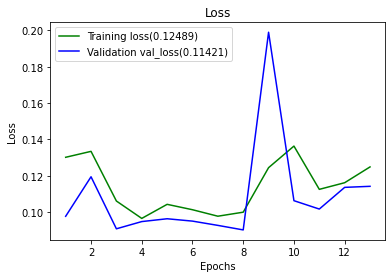

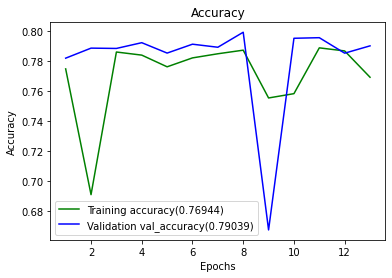

In [ ]:
if preprocess_flag:
  preprocessing_class = DataPreprocessing()
  # Write pickle file
  mappings, texts, labels, max_len_word = preprocessing_class.writeMappings()
  # Delete to save space
  del preprocessing_class
else:
  # Get mappings
  mappings = getMappings()  # num2tag, tag2num, num2word, word2num
  texts, labels, max_len_word = getDataset()

# Load embedding matrix
if loadEmbedding:
  embeddingMatrix, embeddingLookup = loadEmbeddingLookup()
else:
  embeddingMatrix, embeddingLookup = getEmbeddingsLookup('pubmed', mappings[3])

# Shuffle and split dataset in train and test set
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
X_train, X_test = shuffle_and_split(texts, indices, VALIDATION_SPLIT=0.2)
del texts
y_train, y_test = shuffle_and_split(labels, indices, VALIDATION_SPLIT=0.2)
del labels

# Shuffle and split train dataset in train and validation
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train, X_val = shuffle_and_split(X_train, indices, VALIDATION_SPLIT=0.2)
y_train, y_val = shuffle_and_split(y_train, indices, VALIDATION_SPLIT=0.2)

# Get generator class for train and val
generator_train = DataGenerator(X_train, y_train, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_val = DataGenerator(X_val, y_val, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_test = DataGenerator(X_test, y_test, mappings, BATCH_SIZE, max_len_word, embeddingLookup)

# Get Model
bioModel_1 = createBioNerModel_BILSTM(model_name=model_name,embedding_dim_char=100,
                             embedding_matrix=embeddingMatrix,
                             num_classes=len(mappings[0]))

# Use early stopping callback to stop before overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

# Directory to save weights
output_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/saved_weights/"

# Save weights for the best model
model_checkpoint = ModelCheckpoint(filepath=output_dir+model_name+'_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   save_weights_only=True,
                                   verbose=1)
# Train model on dataset
try:
  if load_weights:
    bioModel_1.load_weights(model_weights)
  model_history = bioModel_1.fit(x=generator_train,
                               validation_data=generator_val,
                               epochs=epochs,
                               callbacks=[early_stopping,model_checkpoint],
                               shuffle=False)
except KeyboardInterrupt:
  print("Saving weights...")
  bioModel_1.save_weights(output_dir+model_name+'_model_weights_stop.h5')

# Visualize loss and acc
plot_history(model_name, bioModel_3,crf_flag=crf_flag)

In [ ]:
# Predict on test dataset using model
y_test_pred = bioModel_1.predict(generator_test)
# Finding the class with largest predicted probability
pred_test = y_test_pred.argmax(axis=-1)
# Calculate F1 score
f1_score = Score(y_true=labels_test, y_pred=pred_test,id2label=mappings[0],pad_value=0)


In [ ]:
# Model result
print(' - f1: {:04.5f}'.format(f1_score.score() * 100))

              precision    recall  f1-score   support

 b-cell_line       0.00      0.00      0.00      1600
 b-cell_type       0.24      0.44      0.31      2623
       b-dna       0.24      0.02      0.04      3870
   b-protein       0.39      0.42      0.41     12098
       b-rna       0.00      0.00      0.00       385
 i-cell_line       0.41      0.44      0.42      3141
 i-cell_type       0.76      0.04      0.08      3474
       i-dna       0.23      0.06      0.10      6318
   i-protein       0.00      0.00      0.00      9918
       i-rna       0.00      0.00      0.00       654
           o       0.85      0.96      0.90    153074

    accuracy                           0.79    197155
   macro avg       0.28      0.22      0.21    197155
weighted avg       0.72      0.79      0.74    197155

 - f1: 18.44088


********************************************************************************
Model BLSTM + WE + char + dropout (createBioNerModel_BILSTM_dropout) ran on training dataset with Early stopping criterion based on validation loss improvement with delta set to 0.0001 and patience of 5 epochs. The best weights are saved.
********************************************************************************

In [ ]:
# Parameters for the model
epochs = 20
BATCH_SIZE = 64
preprocess_flag = True
loadEmbedding = False
model_name = "BLSTM _WE_char_dropout"
load_weights = False
crf_flag = False

100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_chars (InputLayer)        [(None, None, None)] 0                                            
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, None, None, 1 7000        input_chars[0][0]                
__________________________________________________________________________________________________
input_words (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
td_lstm_fwd_char (TimeDistribut (None, None, 64)     42240       char_embedding[0][0]             
______________________________________________________________________________________

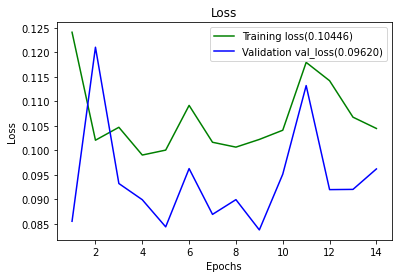

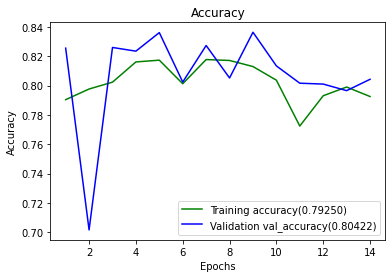

In [ ]:
# Process dataset
if preprocess_flag:
  preprocessing_class = DataPreprocessing()
  # Write pickle files
  mappings, texts, labels, max_len_word = preprocessing_class.writeMappings()
  # Delete to save space
  del preprocessing_class
else:
  # Use already prepared files
  mappings = getMappings()  # num2tag, tag2num, num2word, word2num
  texts, labels, max_len_word = getDataset()

# Shuffle and split dataset in train and test set
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
X_train, X_test = shuffle_and_split(texts, indices, VALIDATION_SPLIT=0.2)
del texts
y_train, y_test = shuffle_and_split(labels, indices, VALIDATION_SPLIT=0.2)
del labels

# Shuffle and split train dataset in train and validation
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train, X_val = shuffle_and_split(X_train, indices, VALIDATION_SPLIT=0.2)
y_train, y_val = shuffle_and_split(y_train, indices, VALIDATION_SPLIT=0.2)

# Get generator class for train and val
generator_train = DataGenerator(X_train, y_train, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_val = DataGenerator(X_val, y_val, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_test = DataGenerator(X_test, y_test, mappings, BATCH_SIZE, max_len_word, embeddingLookup)


# Get generator class for train and validation to enable batch processing
generator_train = DataGenerator(X_train, y_train, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_val = DataGenerator(X_val, y_val, mappings, BATCH_SIZE, max_len_word, embeddingLookup)

# Create model
bioModel_2 = createBioNerModel_BILSTM_dropout(model_name=model_name,embedding_dim_char=100,
                             embedding_matrix=embeddingMatrix,
                             num_classes=len(mappings[0]))

# Directory to save weights
output_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/saved_weights/"

# Use early stopping callback to stop before overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

# Save weights when validation loss improves
model_checkpoint = ModelCheckpoint(filepath=output_dir+model_name+'_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   save_weights_only=True,
                                   verbose=1)

# Train model on dataset
try:
  if load_weights:
    bioModel_2.load_weights(model_weights)
  model_history = bioModel_2.fit(x=generator_train,
                               validation_data=generator_val,
                               epochs=epochs,
                               callbacks=[early_stopping,model_checkpoint],
                               shuffle=False)
except KeyboardInterrupt:
  print("Saving weights...")
  bioModel_2.save_weights(output_dir+model_name+'_model_weights_stop.h5')

# Visualize loss and acc
plot_history(model_name, bioModel_2,crf_flag=crf_flag)

In [ ]:
# Predict on test dataset using model
y_test_pred = bioModel_2.predict(generator_test)
# Finding the class with largest predicted probability
pred_test = y_test_pred.argmax(axis=-1)
# Calculate F1 score
f1_score_2 = Score(y_true=y_test, y_pred=pred_test,id2label=mappings[0],pad_value=0)

In [ ]:
# Print result
print(' - f1: {:04.5f}'.format(f1_score_2.score() * 100))

              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
 b-cell_line       0.00      0.00      0.00      1499
 b-cell_type       0.27      0.02      0.04      2627
       b-dna       0.00      0.00      0.00      3867
   b-protein       0.61      0.10      0.17     11987
       b-rna       0.00      0.00      0.00       414
 i-cell_line       0.00      0.00      0.00      2950
 i-cell_type       0.62      0.24      0.34      3434
       i-dna       0.71      0.33      0.45      6335
   i-protein       0.62      0.29      0.40     10120
       i-rna       0.00      0.00      0.00       658
           o       0.82      0.99      0.89    152967

    accuracy                           0.80    196858
   macro avg       0.30      0.16      0.19    196858
weighted avg       0.74      0.80      0.75    196858

 - f1: 23.11004


******************************************************************************
Model BLSTM + WE + char + dropout + CRF (createBioNerModel) ran on training data with Early stopping criterion based on validation loss improvement with delta set to 0.0001 and patience of 5 epochs. The best weights are saved.
Due to the limited run time in Google Colab initial weights are taken from 4th epoch of one of the previous runs.
********************************************************************************

In [ ]:
# Parameters BLSTM _WE_char_dropout_CRF
epochs = 15
BATCH_SIZE = 64
preprocess_flag = True
loadEmbedding = False
model_name = "BLSTM _WE_char_dropout_CRF"
load_weights = True
crf_flag = True
model_weights = '/content/drive/MyDrive/Colab Notebooks/NNDS project/saved_weights/BLSTM _WE_char_dropout_CRF00000004.h5'


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_chars (InputLayer)        [(None, None, None)] 0                                            
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, None, None, 1 7000        input_chars[0][0]                
__________________________________________________________________________________________________
input_words (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
td_lstm_fwd_char (TimeDistribut (None, None, 64)     42240       char_embedding[0][0]             
_______________________________________________________________________________________

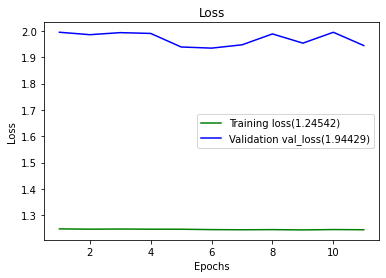

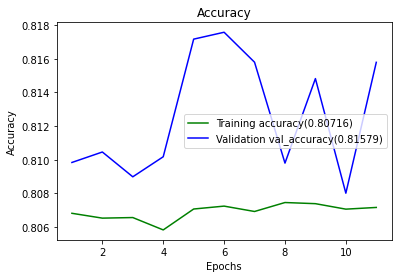

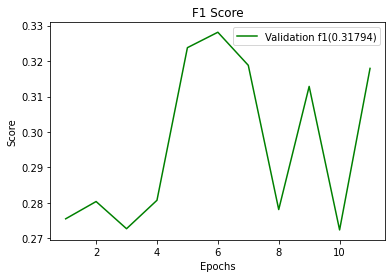

In [ ]:
# Process data
if preprocess_flag:
  preprocessing_class = DataPreprocessing()
  # Write pickle file
  mappings, texts, labels, max_len_word = preprocessing_class.writeMappings()
  # Delete to save space
  del preprocessing_class
else:
  # Get mappings
  mappings = getMappings()  # num2tag, tag2num, num2word, word2num
  texts, labels, max_len_word = getDataset()


# Load embedding matrix
if loadEmbedding:
  embeddingMatrix, embeddingLookup = loadEmbeddingLookup()
else:
  embeddingMatrix, embeddingLookup = getEmbeddingsLookup('pubmed', mappings[3])

# Shuffle and split dataset in train and test set
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
X_train, X_test = shuffle_and_split(texts, indices, VALIDATION_SPLIT=0.2)
del texts
y_train, y_test = shuffle_and_split(labels, indices, VALIDATION_SPLIT=0.2)
del labels

# Shuffle and split train dataset in train and validation
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train, X_val = shuffle_and_split(X_train, indices, VALIDATION_SPLIT=0.2)
y_train, y_val = shuffle_and_split(y_train, indices, VALIDATION_SPLIT=0.2)

# Get generator class for train and val
generator_train = DataGenerator(X_train, y_train, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_val = DataGenerator(X_val, y_val, mappings, BATCH_SIZE, max_len_word, embeddingLookup)
generator_test = DataGenerator(X_test, y_test, mappings, BATCH_SIZE, max_len_word, embeddingLookup)

# Get Model
bioModel_3 = createBioNerModel(model_name=model_name,embedding_dim_char=100,
                             embedding_matrix=embeddingMatrix,
                             num_classes=len(mappings[0]))

# Use early stopping callback to stop before overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.0001,restore_best_weights=True, verbose=1)

# Directory to save results
output_dir = "/content/drive/MyDrive/Colab Notebooks/NNDS project/saved_weights/"


# Save weights when loss improves
model_checkpoint = ModelCheckpoint(filepath=output_dir+model_name+'_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   save_weights_only=True,
                                   verbose=1)


# Callback to get the F1 score at the end of each epoch
f1_callback = F1Metrics(mappings[0], validation_data=generator_val)



# Train model on dataset
try:
  if load_weights:
    bioModel_3.load_weights(model_weights)
  model_history = bioModel_3.fit(x=generator_train,
                               validation_data=generator_val,
                               epochs=epochs,
                               callbacks=[f1_callback,model_checkpoint,early_stopping],
                               shuffle=False)
except KeyboardInterrupt:
  print("Saving weights...")
  bioModel_3.save_weights(output_dir+model_name+'_model_weights_stop.h5')

# Visualize loss and acc
plot_history(model_name, bioModel_3,crf_flag=crf_flag)

In [ ]:
# Predict on test dataset using model
y_test_pred = bioModel_3.predict(generator_test)

# Calculate F1 score
f1_score_3 = Score(y_true=y_test, y_pred=y_test_pred, id2label=mappings[0],pad_value=0)

In [ ]:
# Model result
print('- f1: {:04.5f}'.format(f1_score_3.score() * 100))

              precision    recall  f1-score   support

 b-cell_line       0.67      0.06      0.11      1499
 b-cell_type       0.67      0.06      0.10      2627
       b-dna       0.71      0.15      0.24      3867
   b-protein       0.81      0.13      0.23     11987
       b-rna       0.00      0.00      0.00       414
 i-cell_line       0.65      0.16      0.26      2950
 i-cell_type       0.69      0.19      0.30      3434
       i-dna       0.67      0.38      0.48      6335
   i-protein       0.78      0.36      0.49     10120
       i-rna       0.00      0.00      0.00       658
           o       0.82      0.99      0.90    152967

    accuracy                           0.81    196858
   macro avg       0.59      0.22      0.28    196858
weighted avg       0.80      0.81      0.77    196858

- f1: 31.73180
